# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley 2018

Due Tuesday 2pm, Feb 20, 2018

# 1) Monty: The Python Siri

Let's make a Siri-like program (call it Monty!) with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify (or, e.g., Google Speech https://cloud.google.com/speech/) to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [9]:
# Populate our namespace
import pyaudio
import numpy as np
import wave
#from houndify import * 
import my_credentials 
#pip install word2number #this is a package used to convert strings of written numbers to ints
from word2number import w2n

import houndify #class provided by houndify in order to interface with thier speach to text engine
import time
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json

from email_example import mail




In [10]:
#Defining a function to record audio, I am recycling code from lecture

def record_audio(file_name='' ,path = '',sample_rate = 16000):
    """
    Records audio for an arbitrary amount of time, requires a keyboard interupt to stop the
    recording. A keyboard interupt is 'ii' in a jupyter notebook
    
    Takes input: 
    
    path: the path for the .wav file to be saved, if not specified, it will 
    be saved in the current directory
    file_name: the name of the .wav file to be saved, if not specified, it will
    be named "new_wave.wav"
    
    sample_rate: Must be either 8kHz or 16kHz. If not specified, defaults to 16kHz
    
    Records audio from the building mic with sample rate of 44.1kHz for user defined length of time
    A .wav file is then 
    """
    
    #Check if user gave path/file name, if not, then given defaults
    if len(file_name) != 0:    
        WAVE_OUTPUT_FILENAME = path + file_name + '.wav'        
    else:
        WAVE_OUTPUT_FILENAME = path + "new_wave.wav"
        
    chunk = 1024
    
    FORMAT = pyaudio.paInt16 
    CHANNELS = 1
    RATE = sample_rate
                   
    p = pyaudio.PyAudio()
    print("* Starting recording")
    print(".... press 'ii' to stop the recording .....")
    stream = p.open(format = FORMAT,
        channels = CHANNELS,
        rate = RATE,
        input = True,
        frames_per_buffer = chunk)
    all = []
    
    try:
        while True:
            data = stream.read(chunk)
            all.append(data)
    except:
        KeyboardInterrupt
            
    print("* done recording")
    stream.close()
    p.terminate()
    
    data = b"".join(all)
    wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()
    
    return data
    


In [11]:
def convert_to_text(file_name):
    """
    Modified code provided by Houndify that 
    uses the Houndify class to connect to thier
    speach to text engine to convert provided .wav files to 
    text.
    
    Inputs:
    file_name: name of .wav file (and path if not in same directory) to converted
    to text
    
    Returns:
    words: the text returned by Houndify parsed into a list of words
    
    """

    
    file_name = file_name + '.wav'
    CLIENT_ID = my_credentials.Houndify_Client_ID
    CLIENT_KEY = my_credentials.Houndify_Client_Key
    AUDIO_FILE = file_name
    BUFFER_SIZE = 512

    
    print( 'Converting audio to text.... ')
    client = houndify.StreamingHoundClient(CLIENT_ID, CLIENT_KEY, "monty")
    

    #checks to make sure the audio meets the correct criteria to use Houndify
    audio = wave.open(AUDIO_FILE)
    if audio.getsampwidth() != 2:
      print("%s: wrong sample width (must be 16-bit)" % file_name)
    if audio.getframerate() != 8000 and audio.getframerate() != 16000:
      print("%s: unsupported sampling frequency (must be either 8 or 16 khz)" % file_name)
    if audio.getnchannels() != 1:
      print("%s: must be single channel (mono)" % file_name)

    client.setSampleRate(audio.getframerate())

    client.start()


    while True:
      samples = audio.readframes(BUFFER_SIZE)
      if len(samples) == 0: break
      if client.fill(samples): break

    
    results = client.finish() # returns either final response or error
    

    
    text = results['AllResults'][0]['RawTranscription']
    words = text.split()
    return words
    


In [12]:
def get_joke():
    base_url = "https://api.whatdoestrumpthink.com/api/v1/quotes/random"
    url = base_url
    json_result = json.loads(urlopen(url).read().decode("UTF-8"))
    joke = 'A quote from the President of the United States, Donald J. Drumpf: \n' + json_result['message']
    return joke

In [13]:
def do_task(words):

    email_key = ['mail','email','send','subject','body']
    joke_key = ['joke']
    math_operations = {'times': '*',
                       'multiply':'*', 
                       'add':'+',
                       'plus':'+',
                       'sum':'+',
                       'subtract':'-',
                       'minus':'-',
                       'divide':'/',
                       'divided':'/',
                       'negative':'-',
                       'power':'**'}

    numbers = list()

    if any(keyword in words for keyword in email_key):
        print('\nMonty is sending you an email!')
        
        
        try:
            body_indx = words.index('body') #extracting the body of the email
            body_text = words[body_indx+1:]
        except ValueError: 
            body_indx = len(words)
            body_text = 'No Body detected'
        
        
        try:
            subject_indx = words.index('subject') #extracting the subject of the email
            if words[body_indx-1] == 'and': #removing the 'and' before the user says the word body
                subject_text = words[subject_indx+1:body_indx-1]
            else:
                subject_text = words[subject_indx+1:body_indx]
        except ValueError:
            subject_text = 'No subject detected'        
        
        email_dict = {'subject': ' '.join(map(str,subject_text)),
                      'body': ' '.join(map(str,body_text))}
        
        
        mail(sender=my_credentials.GMAIL_USERNAME, 
        pwd=my_credentials.GMAIL_PASSWORD, 
        to=[my_credentials.GMAIL_USERNAME,],
        subject=email_dict['subject'], 
        text=email_dict['body'], 
         # list of files to attach
        )
        
        print('\nYour email has been sent!')
        
        
    elif any(keyword in words for keyword in joke_key):
        print('\n\nOne joke coming up!\n\n')
        joke = get_joke()
        print(joke)
       
    
    
    elif any(keyword in words for keyword in math_operations.keys()):
        print('\n\nLet\'s do some math!\n\n')
     

        operators = list()
        indx = list()
        parsed_words = list()
        equation = list()


        # check for the word 'for' in a math expression and change to 'four'
        for jj in range(len(words)):
            if words[jj] == 'for':
                words[jj] = 'four'


        # Find all the opperators in the expression
        for word in words:
            for key in math_operations.keys():
                if word == key:
                    operators.append(word)
        
        # Find the indices of all the opperators            
        for operator in operators:
            a = [i for i, opp in enumerate(words) if opp == operator]
            indx.append(np.asarray(a))
        index = sorted(list(set(np.concatenate(indx)))) #keep only the unique indices 

        # We now recombine the words in fragments seperated by the operators
        # we do this because words like 'twenty five' or 'one hundred' will get converted 
        # to numbers incorrectly if we convert each word seperatly. 
        parsed_words.append(' '.join(map(str, words[0:index[0]])))
        for ii in range(len(index)-1):
            parsed_words.append(' '.join(map(str, words[index[ii]+1:index[ii+1]])))
        parsed_words.append(' '.join(map(str, words[index[len(index)-1]+1:])))    


        for iword in range(len(parsed_words)):
            try:
                temp = w2n.word_to_num(parsed_words[iword])
            except ValueError:
                print( ' Invalid operation or number encountered. Please ask another question. ')
                return 
            equation.append(temp)    
            if iword < (len(operators)): 
                equation.append(math_operations[operators[iword]])
        answer = ' '.join(map(str, equation))
        print(answer , ' = ',eval(answer)) 
    
    else:
        print('\n\nMonty is confused by your request! Try again and no mumbling!')

In [14]:
###### #############################
## Run this cell to use Monty
##
## Press shift-enter to run cell and press ii to stop recording
####################################


file_name = 'temp_file'
data = record_audio(file_name )
try:
    words = convert_to_text(file_name)
except:
    print("Monty was not able to understand what you said")
    
return_str = do_task(words)

 


* Starting recording
.... press 'ii' to stop the recording .....
* done recording
Converting audio to text.... 


Let's do some math!


5 * 2.8  =  14.0


# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/spring2018/ay250class13410/resources -> Homeworks -> hw3_sound_files.zip

$\textbf{$\Large$ Explination of algorithm}$. For this problem, I will import each audio file, sum the left and right channels to make the audio mono, and then compute the power spectrum of each file. The frequncies are calculated based on the sample rate of the files. Since the human ear percieves pitch logarithmically, I convert the frequency axis to midi number. This can be done by recognizing that octives follow a geometric progression, an there are 12 semitones (half notes) in an octive. We can use this to map frequencies to midi numbers (0-127) each of which corresponds to a musical note. 
$$
m = 12\log_2\left(\frac{f}{A_4}\right) + 69
$$
(The 69 comes from convention of setting $C_0$ to have $m=0$).

The flaw in doing this is that this scaling assumes equal temperment, meaning the 12 notes per octive on the instrument in question are equally spaced, this is not the case for most standard instruments. This means that for certian notes, if the instrument is somewhat out of tune, the note could be potentially mislabled.

For each file, I then find the midi number corresponding to the max amplituded. I use this to set a cut off for finding remaining peaks. Since we are in midi space, every frequency is rounded to the nearest midi number so the peaks will be delta functions. I then make a set out of these midi numbers to identify the unique values. I then convert this back into frequncies to eliminate harmonics. This is done by checking for integer multiples of the fundamental (lowest frequency signal). Once the harmonics are removed, I convert back to midi number and then from that the corresponding note name. This may be slighly awkward going back and forth between midi number and frequency, but it made finding the peaks increadibly simple.

In [2]:
#populate the namespace

#pip install SoundFile #This is used to read in the audio files
import soundfile as sf
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy import fftpack as fft
from os import listdir
import os
import seaborn as sns
import scipy.signal as signal

import pandas as pd


sns.set_style('darkgrid')



Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [3]:
def return_note_name(freq):
    step = convert_to_half_steps(freq)
    notes = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    octive_number = step // 12 - 1
    note_name = step % 12
    return notes[note_name]+str(octive_number)


def convert_to_half_steps(freq):
    A4 = 440 #Standard reference frequency for standard modern instruments
    half_step = np.round(12*np.log2(freq/A4)) + 69 # the 69 is needed so that C0 has midi number one
    half_step = half_step.astype(np.int16)
    return half_step

def convert_to_freq(m):
    A4 = 440
    freq = A4*2**((m-69)/12)
    return freq

def remove_dupes(notes):
    good_notes = list()
    fundamental = np.min(notes)
    good_notes.append(fundamental)
    for note in notes:
        if np.abs(1-((note/fundamental)%1)) >= 0.01:
            if (note/fundamental)%1 != 0.0:
                good_notes.append(note)
    
    return good_notes
            
def find_notes(freqs, power_spectrum):
    
    weighting = 0.2
    freqs_to_keep = list()
    final_notes = list()
    half_steps = convert_to_half_steps(freqs)
    cut_off = np.ones(len(freqs))*weighting*np.max(power_spectrum)
    indx = np.where(power_spectrum>cut_off)
    half_steps_to_keep = set(half_steps[indx])
    for step in half_steps_to_keep:
        freqs_to_keep.append(convert_to_freq(step))
      
    freqs_no_dupes = remove_dupes(freqs_to_keep)
    
    for fn in freqs_no_dupes:
        final_notes.append(return_note_name(fn))
    return final_notes


In [5]:
#Import all the files in a directory

path = 'data/sound_files/'

data_files = {}

for file in listdir(path):
    filename, file_extension = os.path.splitext(file)
    if file_extension == '.aif':
        data, fs = sf.read(path+file, dtype='int32')
        data_files[file] = [fs,data[:,0]+data[:,1]] #add the sample rate and the data to a dictionary, also make the stereo data mono
    

    
#create frequencies, since all files have the same sample rate, we can use the same frequencies for all files    
N = len(data_files['1.aif'][1])
freqs = fft.rfftfreq(N, d = 1/data_files['1.aif'][0])    
    
# Now create a dictionary for the power spectra

power_spectra = {}
for key in data_files.keys():

    power_spec = np.abs(fft.rfft(data_files[key][1]))**2
    power_spectra[key] = power_spec

# find note names for each file    
results = {}
for key in power_spectra.keys():
    
    result = find_notes(freqs, power_spectra[key])
    results[key] = result    


results = {}
for key in power_spectra.keys():
    
    result = find_notes(freqs, power_spectra[key])
    results[key] = result


/Users/cwfink/anaconda3/envs/bootcamp-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()


In [6]:
# Put into pandas dataframe to show the results in a nice way

df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ['Note 1','Note 2','Note 3']
df.index.names = ['File']
df

,Note 1,Note 2,Note 3
File,,,
C4+A4_PopOrgan.aif,C4,A4,None
A4_PopOrgan.aif,A4,None,None
8.aif,F4,None,None
9.aif,G3,None,None
F3_PopOrgan.aif,F3,None,None
11.aif,E2,None,None
10.aif,C2,None,None
12.aif,C2,None,None
7.aif,A6,None,None


In [7]:
def make_plot(freqs, power_spectrum, key, lgc_dBm ):
    weighting = 0.2
    
    cut_off = np.ones(len(freqs))*weighting*np.max(power_spectrum)
    
    plt.figure()
    title_str = "Example plot for file: "+key
    plt.title(title_str)
    cut_off_label = 'Cut off for peak detection'
    if lgc_dBm:
        y = 3*np.log10(power_spectra['A4_PopOrgan.aif']/(.632360**2))
        y_cutoff = 3*np.log10(cut_off/(.632360**2))
    
    
        plt.plot(freqs, y, label = key )
        plt.plot(freqs, y_cutoff, '--', label = cut_off_label)
    
        plt.ylabel(r'dBm/Hz')
    
    else:
        plt.plot(freqs,power_spectrum, label = key)
        plt.plot(freqs, cut_off, '--', label = cut_off_label)
        plt.ylabel(r'Amplitude [V$^2$/Hz]')
    
    
    
    plt.xscale('log')
    
    plt.xlabel('Frequency [Hz]')
    plt.xlim(20,20000)
    
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


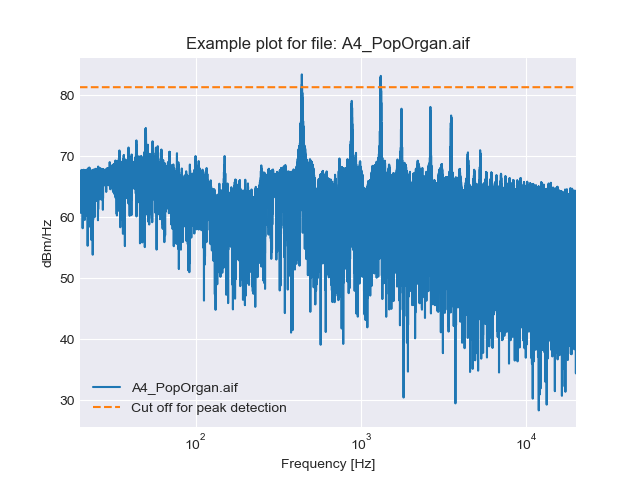

In [8]:
#Example plot


make_plot(freqs, power_spectra['A4_PopOrgan.aif'], 'A4_PopOrgan.aif',lgc_dBm=True)